<a href="https://colab.research.google.com/github/freshpex/AI-Final-Project/blob/main/AI_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib


In [121]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam


##### Combined All Datasets

In [122]:
# Load datasets
datasets = {
    'Tesla': 'datasets/tesla.csv',
    'Apple': 'datasets/apple.csv',
    'LG': 'datasets/lgtelevision.csv',
    'Netflix': 'datasets/netflix.csv',
    'Google': 'datasets/google.csv'
}

dataframes = []

for company, file_path in datasets.items():
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
    df['Company'] = company
    dataframes.append(df)

# Combine all dataframes
combined_df = pd.concat(dataframes)

# Set MultiIndex
combined_df.set_index(['Company', 'Date'], inplace=True)

# Ensure column order
combined_df = combined_df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

# Save combined dataframe
combined_df.to_csv('datasets/stock.csv')


C:\Users\epeki\AppData\Local\Temp\ipykernel_1528\2373198153.py:14: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
C:\Users\epeki\AppData\Local\Temp\ipykernel_1528\2373198153.py:14: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
C:\Users\epeki\AppData\Local\Temp\ipykernel_1528\2373198153.py:14: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is no

In [123]:
file = 'datasets/stock.csv'

df = pd.read_csv(file)
df.head(5)

,Company,Date,Open,High,Low,Close,Adj Close,Volume
0,Tesla,2010-06-29 00:00:00,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,Tesla,2010-06-30 00:00:00,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,Tesla,2010-07-01 00:00:00,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,Tesla,2010-07-02 00:00:00,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,Tesla,2010-07-06 00:00:00,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [124]:
# Calculate and print the range and mean of stock prices
min_price = df['Close'].min()
max_price = df['Close'].max()
mean_price = df['Close'].mean()

print(f"Minimum Stock Price: {min_price}")
print(f"Maximum Stock Price: {max_price}")
print(f"Mean Stock Price: {mean_price}")

Minimum Stock Price: 0.049107
Maximum Stock Price: 2521.6
Mean Stock Price: 117.134226447155


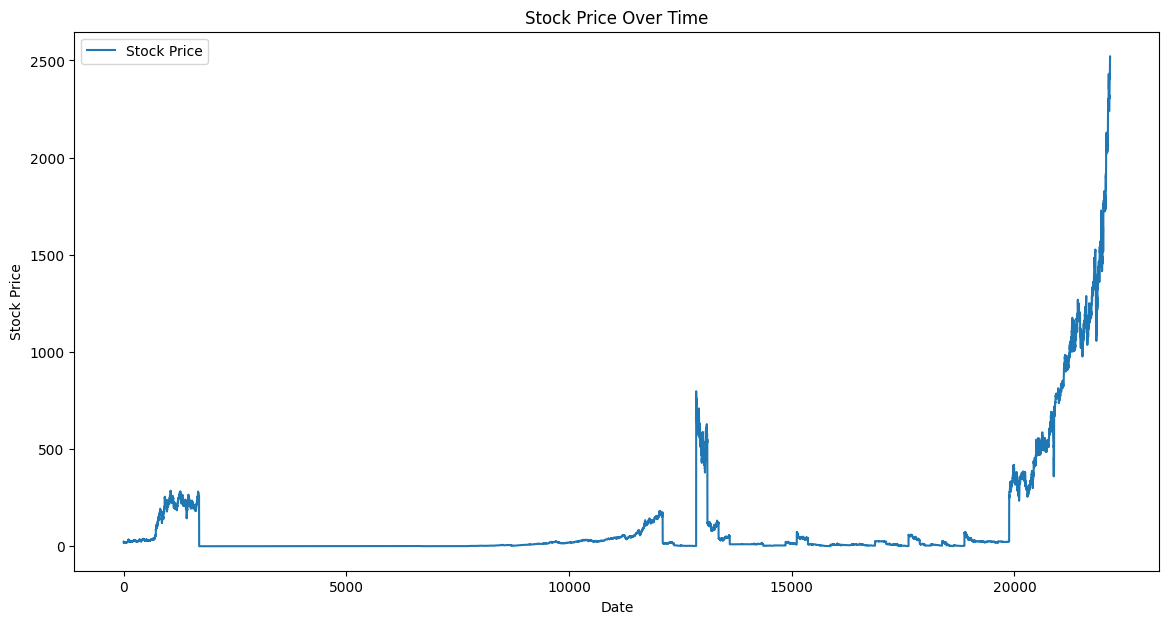

In [125]:
# Plot the stock prices
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Stock Price')
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22149 entries, 0 to 22148
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Company    22149 non-null  object 
 1   Date       22149 non-null  object 
 2   Open       22149 non-null  float64
 3   High       22149 non-null  float64
 4   Low        22149 non-null  float64
 5   Close      22149 non-null  float64
 6   Adj Close  22149 non-null  float64
 7   Volume     22149 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 1.4+ MB


In [127]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,22149.000000,22149.000000,22149.000000,22149.000000,22149.000000,2.214900e+04
mean,117.083751,118.543388,115.649940,117.134226,116.675467,1.571367e+08
std,305.751233,309.047220,302.740774,306.019665,306.014711,2.851121e+08
min,0.049665,0.049665,0.049107,0.049107,0.038384,0.000000e+00
25%,0.531250,0.539063,0.520000,0.531250,0.443849,4.819000e+05
50%,9.750000,9.890000,9.500000,9.740000,9.500000,7.755900e+06
75%,39.014999,39.650002,38.457500,39.000000,38.230000,2.040248e+08
max,2524.920000,2526.990000,2498.290000,2521.600000,2521.600000,7.421641e+09


In [128]:
# Remove time and timezone from 'Date' column
df['Date'] = df['Date'].str.split(' ').str[0]

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the data by Company and Date
df.sort_values(['Company', 'Date'], inplace=True)

# Reset the index
df.reset_index(drop=True, inplace=True)


##### LSTM

In [129]:
# Feature Scaling
scalers = {}
scaled_data = []

for company in df['Company'].unique():
    company_data = df[df['Company'] == company].copy()
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_company_data = scaler.fit_transform(company_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])
    scalers[company] = scaler
    scaled_company_data = pd.DataFrame(scaled_company_data, columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
    scaled_company_data['Company'] = company
    scaled_company_data['Date'] = company_data['Date'].values
    scaled_data.append(scaled_company_data)
    

In [130]:
# Combine all scaled data
scaled_df = pd.concat(scaled_data)

scaled_df.sort_values(['Company', 'Date'], inplace=True)

scaled_df.reset_index(drop=True, inplace=True)

# Display first few rows to verify the result
scaled_df.head()

,Open,High,Low,Close,Adj Close,Volume,Company,Date
0,0.000431,0.000433,0.000443,0.000435,0.000341,0.063198,Apple,1980-12-12
1,0.000397,0.000397,0.000405,0.000399,0.000312,0.023699,Apple,1980-12-15
2,0.000348,0.000348,0.000355,0.000350,0.000274,0.014246,Apple,1980-12-16
3,0.000361,0.000363,0.000371,0.000365,0.000286,0.011647,Apple,1980-12-17
4,0.000379,0.000381,0.000390,0.000383,0.000300,0.009897,Apple,1980-12-18


**Training** **and** **Testing**

In [143]:
time_step = 60
# Prepare Data for LSTM
def create_sequences(data, time_step):
    x, y = [], []
    for i in range(time_step, len(data)):
        x.append(data[i-time_step:i])
        y.append(data[i, 3])
    return np.array(x), np.array(y)

In [132]:
# Create sequences for each company
company_sequences = {}
for company in scaled_df['Company'].unique():
    company_data = scaled_df[scaled_df['Company'] == company].drop(['Company', 'Date'], axis=1).values
    x, y = create_sequences(company_data)
    company_sequences[company] = (x, y)
    

In [133]:
#  Combine all company sequences
x_combined = np.concatenate([v[0] for v in company_sequences.values()])
y_combined = np.concatenate([v[1] for v in company_sequences.values()])

# Split the data into training and testing sets
train_size = int(len(x_combined) * 0.8)
x_train, x_test = x_combined[:train_size], x_combined[train_size:]
y_train, y_test = y_combined[:train_size], y_combined[train_size:]

**Build and Train**

In [134]:
# Build the LSTM model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_combined.shape[1], x_combined.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


c:\Users\epeki\scoop\apps\python\current\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Train Model**

In [135]:
# Train the model
hist = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_split=0.2)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - loss: 0.0059 - val_loss: 0.0137
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - loss: 0.0046 - val_loss: 0.0134
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 0.0050 - val_loss: 0.0115
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step - loss: 0.0034 - val_loss: 0.0116
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 106ms/step - loss: 0.0036 - val_loss: 0.0073
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - loss: 0.0028 - val_loss: 0.0041
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - loss: 0.0023 - val_loss: 0.0072
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - loss: 0.0034 - val_loss: 0.0116
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 38s 101ms/step - loss: 0.0035 - val_loss: 0.0124
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 33s 151ms/step - loss: 0.0017 - val_loss: 0.0069
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 34s 121ms/step - loss: 0.0015 - val_loss: 0.0051
Epoch 12/20
219/219 ━━━━━

**Plot the Loss**

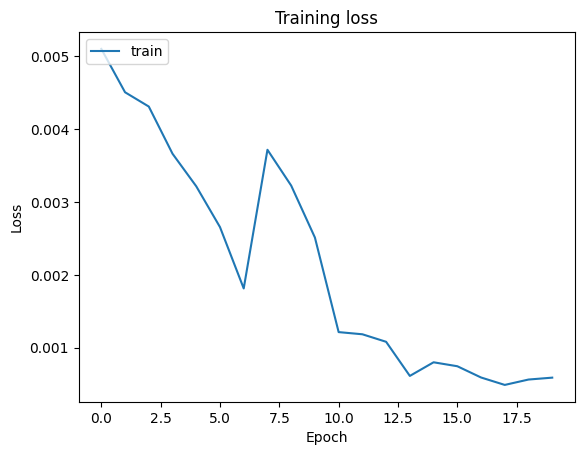

In [136]:
plt.plot(hist.history['loss'])
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train'], loc='upper left')
plt.show()

**Predictions**

In [146]:
# Predict
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)



547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step


In [139]:
# Make predictions
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

547/547 ━━━━━━━━━━━━━━━━━━━━ 27s 48ms/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step


In [140]:
# Inverse transform the predictions and true values
for company in scalers:
    scaler = scalers[company]
    company_index = scaled_df[scaled_df['Company'] == company].index
    company_train_index = [i for i in company_index if i < train_size]
    company_test_index = [i for i in company_index if i >= train_size]

    if company_train_index:
        inverse_transformed_train = scaler.inverse_transform(
            np.hstack((np.zeros((len(company_train_index), 4)), train_predict[company_train_index].reshape(-1, 1), np.zeros((len(company_train_index), 1))))
        )
        train_predict[company_train_index] = inverse_transformed_train[:, 4]

    if company_test_index:
        inverse_transformed_test = scaler.inverse_transform(
            np.hstack((np.zeros((len(company_test_index), 4)), test_predict[company_test_index].reshape(-1, 1), np.zeros((len(company_test_index), 1))))
        )
        test_predict[company_test_index] = inverse_transformed_test[:, 4]


ValueError: shape mismatch: value array of shape (10409,) could not be broadcast to indexing result of shape (10409,1)

In [147]:
# Inverse transform y_train and y_test
y_train_inverse = np.zeros_like(y_train)
y_test_inverse = np.zeros_like(y_test)

for company in scalers:
    scaler = scalers[company]
    company_index = scaled_df[scaled_df['Company'] == company].index
    company_train_index = [i for i in company_index if i < train_size]
    company_test_index = [i for i in company_index if i >= train_size]

    if company_train_index:
        inverse_transformed_y_train = scaler.inverse_transform(
            np.hstack((np.zeros((len(company_train_index), 4)), y_train[company_train_index].reshape(-1, 1), np.zeros((len(company_train_index), 1))))
        )
        y_train_inverse[company_train_index] = inverse_transformed_y_train[:, 4]

    if company_test_index:
        inverse_transformed_y_test = scaler.inverse_transform(
            np.hstack((np.zeros((len(company_test_index), 4)), y_test[company_test_index].reshape(-1, 1), np.zeros((len(company_test_index), 1))))
        )
        y_test_inverse[company_test_index] = inverse_transformed_y_test[:, 4]


IndexError: index 17479 is out of bounds for axis 0 with size 4370

**Plot Predictions**

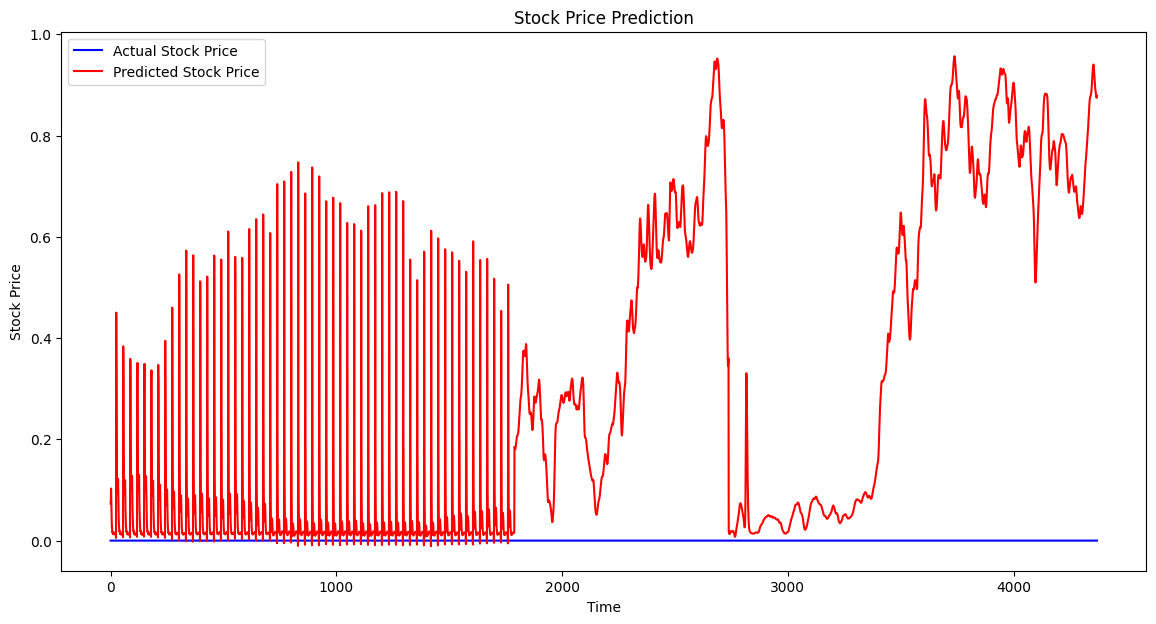

In [148]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse, color='blue', label='Actual Stock Price')
plt.plot(test_predict, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

##### Performance Metrics

In [ ]:
# Performance Metrics
mse = mean_squared_error(y_test, test_predict)
rmse = np.sqrt(mse)

# Print the performance metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 14736.494509412612
Root Mean Squared Error (RMSE): 121.39396405675454


##### Test Model with a Dataset in the Combined dataset

In [ ]:
# Load the trained model
model = tf.keras.models.load_model('stock_prediction.h5')

# Load a new dataset to test
file = 'datasets/apple.csv'
test_data = pd.read_csv(file)
test_data['Date'] = pd.to_datetime(test_data['Date'])
test_data.set_index('Date', inplace=True)
test_data = test_data.dropna()

# Normalize the dataset using the same scaler
scaler = scalers['Tesla']
input_scaled = scaler.transform(test_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].values)


c:\Users\epeki\scoop\apps\python\current\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Initialize variables for testing
x_test = []
time_step = 60 
length = len(test_data)

# Create input sequences for the test model
for i in range(time_step, length):
    x_test.append(input_scaled[i-time_step:i])

In [ ]:
# Convert to numpy array and reshape
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

# Make predictions
y_pred = model.predict(x_test)

# Inverse transform predictions
predicted_price = scaler.inverse_transform(np.concatenate((np.zeros((y_pred.shape[0], input_scaled.shape[1]-1)), y_pred), axis=1))[:, 3]

# Get the actual closing prices for comparison
y_test = test_data['Close'].values[time_step:]

324/324 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


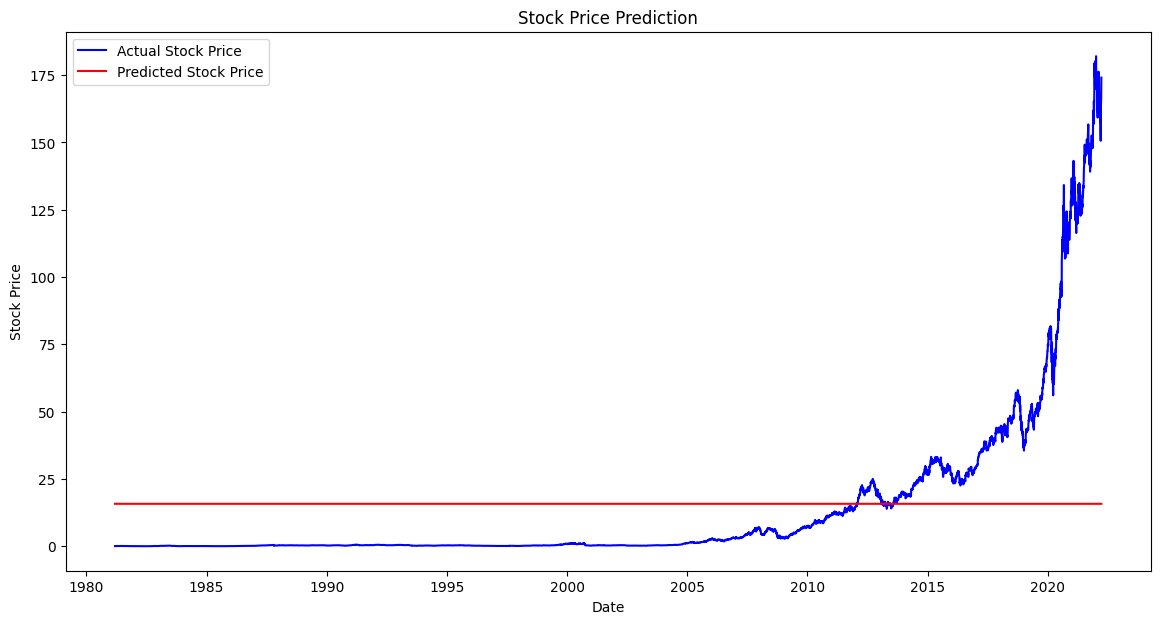

In [ ]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(test_data.index[time_step:], y_test, color='blue', label='Actual Stock Price')
plt.plot(test_data.index[time_step:], predicted_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_test, predicted_price)
rmse = np.sqrt(mse)

# Print the performance metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 918.6917810312327
Root Mean Squared Error (RMSE): 30.30992875331832


# Create and Save Model

In [ ]:
# Save the trained model
model.save('stock_prediction.h5')


In [ ]:
# Save the scaler for each company
for company, scaler in scalers.items():
    joblib.dump(scaler, f'scaler_{company}.pkl')